Requirements to run this notebook:

1. [Install `perfcapture` and its dependencies in a new virtual environment](https://github.com/zarr-developers/perfcapture).
2. Activate that venv.
3. Install additional Python dependencies within the venv: `pip install ipykernel zarr matplotlib`
4. Optionally, install `fio` to benchmark your local hard disk. (On Ubuntu: `sudo apt install fio`)

# Analyse `results.csv`

In [21]:
import pandas as pd
import numpy as np

In [86]:
results = pd.read_csv("results.csv")
results.head()

# Remove suspiciously low busy_time_secs:
mask = results["busy_time_secs"] < 0.01
results.loc[mask, "busy_time_secs"] = np.NaN

# Calculate the "read GB / busy_time_secs":
results["read GB / busy_time_secs"] = results["read GB"] / results["busy_time_secs"]

In [87]:
results

,workload,dataset,run_ID,Runtime in secs,GB/sec to numpy,read_count,write_count,read_merged_count,write_merged_count,read_IOPS,...,avg read GB/sec,avg write GB/sec,read GB / read_time_secs,write GB / write_time_secs,read GB,write GB,read_time_secs,write_time_secs,busy_time_secs,read GB / busy_time_secs
0,TensorStoreLoadEntireArray,Uncompressed_1_Chunk,1,0.932439,1.072456,1542.0,1.0,3.0,0.0,1653.727482,...,1.072458,0.000004,2.590678,0.000683,1.000002,0.000004,0.386,0.006,0.492,2.032523
1,TensorStoreLoadEntireArray,Uncompressed_1_Chunk,2,0.952963,1.049359,1544.0,0.0,3.0,0.0,1620.209809,...,1.049365,0.000000,2.538085,0.000000,1.000006,0.000000,0.394,0.000,0.512,1.953136
2,TensorStoreLoadEntireArray,Uncompressed_1_Chunk,3,0.957217,1.044695,1544.0,0.0,3.0,0.0,1613.009380,...,1.044701,0.000000,2.544544,0.000000,1.000006,0.000000,0.393,0.000,0.512,1.953136
3,TensorStoreLoadEntireArray,LZ4_200_Chunks,1,0.236587,4.226775,1.0,0.0,0.0,0.0,4.226775,...,0.002216,0.000000,0.000000,0.000000,0.000524,0.000000,0.000,0.000,NaN,NaN
4,TensorStoreLoadEntireArray,LZ4_200_Chunks,2,0.195299,5.120354,1796.0,0.0,314.0,0.0,9196.155638,...,4.829362,0.000000,0.042604,0.000000,0.943170,0.000000,22.138,0.000,0.136,6.935070
5,TensorStoreLoadEntireArray,LZ4_200_Chunks,3,0.195131,5.124762,1818.0,0.0,333.0,0.0,9316.817933,...,4.833520,0.000000,0.043067,0.000000,0.943170,0.000000,21.900,0.000,0.140,6.736925
6,TensorStoreLoadEntireArray,Uncompressed_200_Chunks,1,0.184764,5.412310,0.0,51.0,0.0,0.0,0.000000,...,0.000000,0.232285,0.000000,0.159546,0.000000,0.042918,0.000,0.269,NaN,NaN
7,TensorStoreLoadEntireArray,Uncompressed_200_Chunks,2,0.197481,5.063778,1774.0,0.0,176.0,0.0,8983.142682,...,5.065031,0.000000,0.042101,0.000000,1.000247,0.000000,23.758,0.000,0.148,6.758428
8,TensorStoreLoadEntireArray,Uncompressed_200_Chunks,3,0.201101,4.972626,1809.0,0.0,208.0,0.0,8995.479883,...,4.973855,0.000000,0.043323,0.000000,1.000247,0.000000,23.088,0.000,0.148,6.758428
9,TensorStoreLoadEntireArray,LZ4_20000_Chunks,1,1.560889,0.640661,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000,NaN,NaN


In [88]:
def get_result(column) -> pd.DataFrame:
    mean_result = results.groupby(["workload", "dataset"])[column].mean()
    return mean_result.to_frame().pivot_table(
        columns="workload",
        index="dataset"
    ).loc[[
        "NumpyNPY",
        "Uncompressed_1_Chunk",
        "Uncompressed_200_Chunks",
        "LZ4_200_Chunks",
        "Uncompressed_20000_Chunks",
        "LZ4_20000_Chunks"]
    ].droplevel(0, axis="columns")

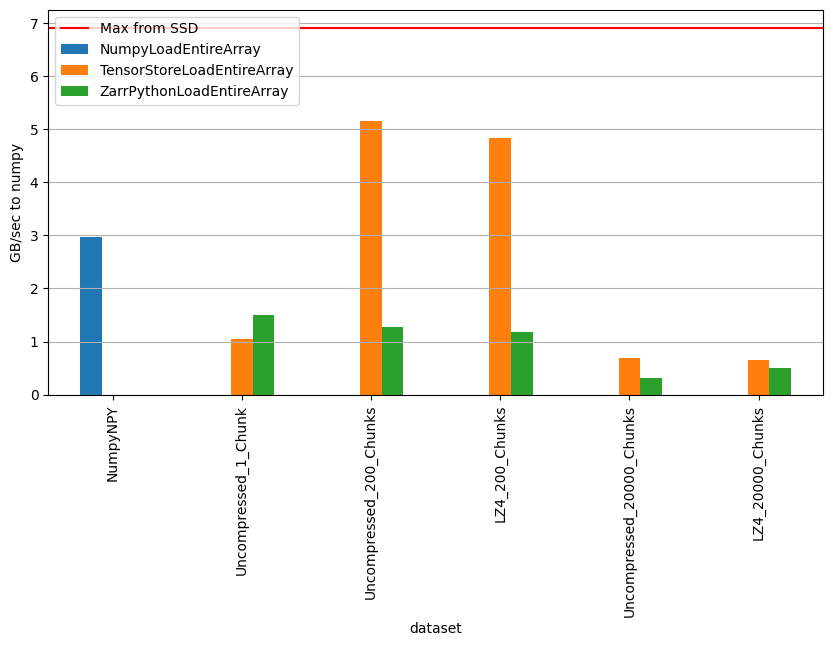

In [89]:
column_name = "GB/sec to numpy"
ax = get_result(column_name).plot.bar(figsize=(10, 5))
ax.set_ylabel(column_name)

# Draw "IO bandwidth" line
# fio --name=read --direct=1 --rw=read --ioengine=io_uring --iodepth=512 --directory=/mnt/storage_ssd_4tb/fio --size=1g --bs=32k
max_gbytes_per_sec = 6.9
ax.plot(ax.get_xlim(), (max_gbytes_per_sec, max_gbytes_per_sec), color="red", label="Max from SSD")
ax.legend(loc='upper left');
ax.grid(axis="y")

Text(0.5, 1.0, 'Throughput from disk')

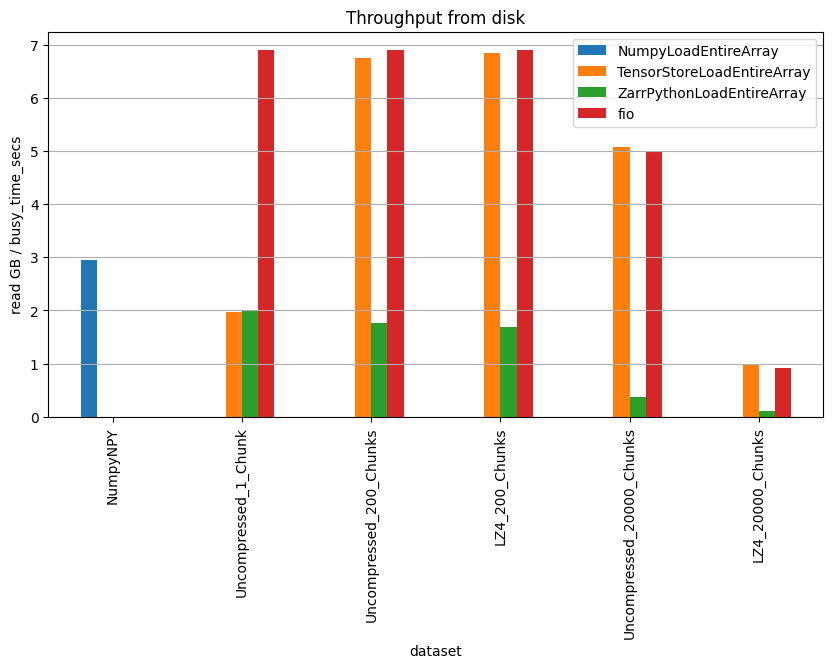

In [94]:
column_name = "read GB / busy_time_secs"
df = get_result(column_name)

# fio --name=read --direct=1 --rw=read --ioengine=io_uring --iodepth=512 --directory=/mnt/storage_ssd_4tb/fio --size=1g --bs=32k
df.loc["Uncompressed_1_Chunk", 'fio'] = 6.9

# fio --name=read --direct=1 --rw=read --ioengine=io_uring --iodepth=128 --directory=/mnt/storage_ssd_4tb/fio --nrfiles=200 --filesize=4800k --bs=128k
df.loc['Uncompressed_200_Chunks', 'fio'] = 6.9

# fio --name=read --direct=1 --rw=read --ioengine=io_uring --iodepth=128 --directory=/mnt/storage_ssd_4tb/fio --nrfiles=200 --filesize=4500k --bs=64k
df.loc['LZ4_200_Chunks', 'fio'] = 6.9

# fio --name=read --direct=1 --rw=read --ioengine=io_uring --iodepth=256 --directory=/mnt/storage_ssd_4tb/fio --nrfiles=20000 --filesize=49k --bs=49k --openfiles=100
df.loc['Uncompressed_20000_Chunks', 'fio'] = 5.0

# fio --name=read --direct=1 --rw=read --ioengine=io_uring --iodepth=256 --directory=/mnt/storage_ssd_4tb/fio --nrfiles=20000 --filesize=8k --bs=8k --openfiles=1000
df.loc['LZ4_20000_Chunks', 'fio'] = 0.92


ax = df.plot.bar(figsize=(10, 5))
ax.set_ylabel(column_name)
ax.legend(loc='upper right')
ax.grid(axis="y")
ax.set_title("Throughput from disk")

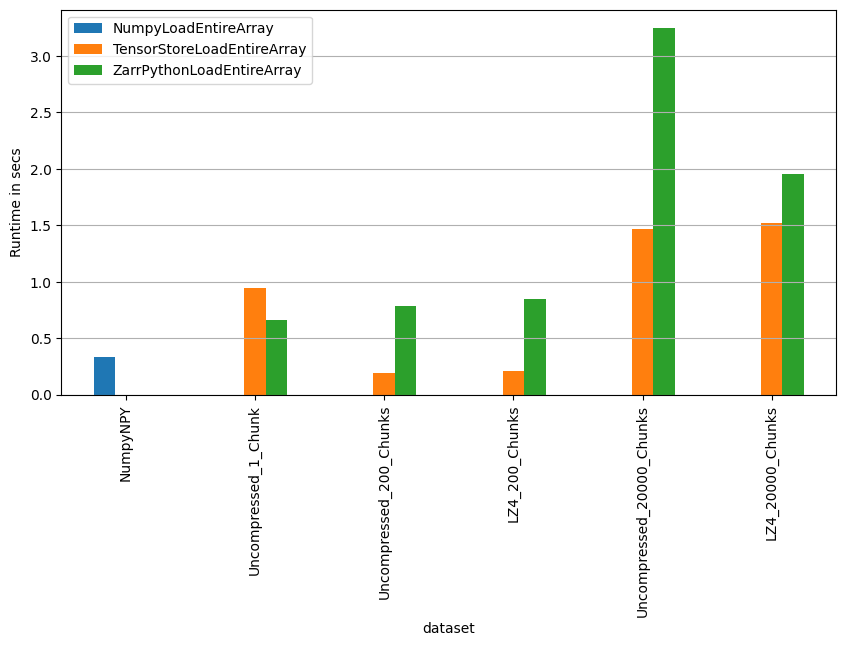

In [91]:
column_name = "Runtime in secs"
ax = get_result(column_name).plot.bar(figsize=(10, 5))
ax.set_ylabel(column_name)

ax.legend(loc='upper left');
ax.grid(axis="y")